In [1]:
import os
import re
import json
import pickle
import random
import warnings
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
from google.colab import drive

warnings.filterwarnings("ignore")

In [2]:
# Пути к данным
house_path = "/content/data/house_dataset.csv"
antagonists_path = "/content/data/antagonists_dataset.csv"

# Загрузка данных
house_df = pd.read_csv(house_path)
antagonists_df = pd.read_csv(antagonists_path)

# Вывод первых строк для проверки
print("Первые строки датасета Доктора Хауса:")
print(house_df.head())

print("Первые строки датасета антагонистов:")
print(antagonists_df.head())

Первые строки датасета Доктора Хауса:
    name  season                                      previous_line  \
0  house       1  Fair enough. I dont like healthy Patients. The...   
1  house       1  Shouldnt we be speaking to the Patient before ...   
2  house       1                                           No, but!   
3  house       1      Isnt treating Patients why we became doctors?   
4  house       1                                           Mad cow?   

  previous_speaker                                       context_long  \
0           wilson  See that? They all assume Im a Patient because...   
1          foreman  And shes not responding to radiation treatment...   
2          foreman  Come on! Why leave all the fun for the coroner...   
3          foreman  Shouldnt we be speaking to the Patient before ...   
4            chase  First year of medical school if you hear hoof ...   

   is_greeting  is_question  is_negation  is_exclamation  is_sarcasm  \
0        False        Fa

In [3]:
def clean_text(text):
    """Очистка текста от проблемных символов, лишних пробелов и мусора."""
    if not isinstance(text, str) or len(text) == 0:
        return ""

    text = text.replace("�", "")
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"[^\x00-\x7F]+", "", text)

    return text

def additional_cleaning(text):
    """Дополнительная очистка с учетом чисел, процентов, дробей и случайных заглавных букв."""
    if not isinstance(text, str):
        return text

    # Разрешенные символы: буквы, цифры, пробелы, знаки пунктуации, проценты, доллар, дроби
    text = re.sub(r"[^\w\s.,!?'$/%-]", "", text)

    # Удаление лишних пробелов
    text = re.sub(r"\s+", " ", text).strip()

    # Исправление случайных заглавных букв в середине слова
    words = text.split()
    cleaned_words = []
    for word in words:
        if re.search(r"[A-Z][a-z]+[A-Z]", word):  # Проверка случайной заглавной буквы в середине слова
            word = word.lower()
        cleaned_words.append(word)

    return " ".join(cleaned_words)

def apply_text_cleaning(df, text_columns):
    """Очистка всех указанных текстовых колонок и сбор статистики."""

    stats = {}

    for col in text_columns:
        initial_non_empty = df[col].notna().sum()  # Количество непустых значений до очистки
        total_chars_before = df[col].dropna().apply(len).sum()  # Общее количество символов до очистки

        # Очистка
        df[col] = df[col].astype(str).apply(clean_text).apply(additional_cleaning)

        total_chars_after = df[col].dropna().apply(len).sum()  # Общее количество символов после очистки
        cleaned_chars = total_chars_before - total_chars_after  # Удалено символов
        final_non_empty = df[col].notna().sum()  # Количество непустых значений после очистки

        stats[col] = {
            "исходные строки": initial_non_empty,
            "очищенные строки": final_non_empty,
            "удалено пустых строк": initial_non_empty - final_non_empty,
            "общая длина до очистки": total_chars_before,
            "общая длина после очистки": total_chars_after,
            "удалено символов": cleaned_chars,
        }

    return df, stats

# Определение всех текстовых колонок, которые нужно очистить
text_columns_house = ["line", "previous_line", "context_1", "context_2", "context_3", "context_4", "context_5", "context_long"]
text_columns_antagonists = ["line"]

# Очистка текстовых колонок в датасете Доктора Хауса и Антагонистов
house_df, house_stats = apply_text_cleaning(house_df, text_columns_house)
antagonists_df, antagonists_stats = apply_text_cleaning(antagonists_df, text_columns_antagonists)

# Вывод статистики для Доктора Хауса
print("\nСТАТИСТИКА ОЧИСТКИ: ДОКТОР ХАУС")
for col, stats in house_stats.items():
    print(f"\nКолонка: {col}")
    for key, value in stats.items():
        print(f"- {key}: {value}")

# Вывод статистики для Антагонистов
print("\nСТАТИСТИКА ОЧИСТКИ: АНТАГОНИСТЫ")
for col, stats in antagonists_stats.items():
    print(f"\nКолонка: {col}")
    for key, value in stats.items():
        print(f"- {key}: {value}")

# Примеры изменений до и после очистки
print("\nПРИМЕРЫ ДО И ПОСЛЕ ОЧИСТКИ:")

for col in text_columns_house:
    sample_before = house_df[col].dropna().sample(1, random_state=42).values[0]
    sample_after = additional_cleaning(clean_text(sample_before))
    print(f"\nКолонка: {col}")
    print(f"До: {sample_before}")
    print(f"После: {sample_after}")



СТАТИСТИКА ОЧИСТКИ: ДОКТОР ХАУС

Колонка: line
- исходные строки: 8557
- очищенные строки: 8557
- удалено пустых строк: 0
- общая длина до очистки: 625471
- общая длина после очистки: 624772
- удалено символов: 699

Колонка: previous_line
- исходные строки: 8556
- очищенные строки: 8557
- удалено пустых строк: -1
- общая длина до очистки: 471335
- общая длина после очистки: 470778
- удалено символов: 557

Колонка: context_1
- исходные строки: 8557
- очищенные строки: 8557
- удалено пустых строк: 0
- общая длина до очистки: 1260155
- общая длина после очистки: 1258465
- удалено символов: 1690

Колонка: context_2
- исходные строки: 8557
- очищенные строки: 8557
- удалено пустых строк: 0
- общая длина до очистки: 1742933
- общая длина после очистки: 1740463
- удалено символов: 2470

Колонка: context_3
- исходные строки: 8557
- очищенные строки: 8557
- удалено пустых строк: 0
- общая длина до очистки: 2237341
- общая длина после очистки: 2234105
- удалено символов: 3236

Колонка: context_

In [4]:
# Параметры фильтрации
MAX_REPLIES_PER_CHARACTER = 5000
MIN_HOUSE_WORD_COUNT = 3  # Минимальное количество слов в реплике для Доктора Хауса
MIN_ANTAGONISTS_WORD_COUNT = 5  # Минимальное количество слов в реплике для Антагонистов
MIN_LINE_LENGTH = 10  # Минимальная длина реплики в символах

def count_words(text):
    """Подсчет количества слов в тексте."""
    return len(text.split()) if isinstance(text, str) else 0

def filter_dataframe(df, min_word_count, text_column="line", group_by_character=True):
    """Удаление пустых строк, коротких реплик, вопросов, дубликатов и подозрительных символов."""

    initial_count = len(df)

    # Удаление пустых значений
    df = df.dropna(subset=[text_column]).reset_index(drop=True)
    after_na_removal = len(df)

    # Удаление слишком коротких реплик
    df = df[df[text_column].str.len() >= MIN_LINE_LENGTH].reset_index(drop=True)
    after_length_filter = len(df)

    # Удаление вопросов
    df = df[~df[text_column].str.match(r"^[^.!?]+\?$", na=False)].reset_index(drop=True)
    df = df[~df[text_column].str.endswith("?")].reset_index(drop=True)
    after_question_filter = len(df)

    # Удаление дубликатов
    df = df.drop_duplicates(subset=[text_column]).reset_index(drop=True)
    after_duplicates_removal = len(df)

    # Фильтрация реплик по количеству слов
    df["word_count"] = df[text_column].apply(count_words)
    df = df[df["word_count"] >= min_word_count].drop(columns=["word_count"]).reset_index(drop=True)
    after_word_count_filter = len(df)

    # Ограничение количества реплик на персонажа
    if group_by_character and "character" in df.columns:
        df = df.groupby("character").apply(
            lambda x: x.sample(n=min(len(x), MAX_REPLIES_PER_CHARACTER), random_state=42)
        ).reset_index(drop=True)

    final_count = len(df)

    # Вывод статистики по удалению строк
    print(f"Удалено пустых строк: {initial_count - after_na_removal}")
    print(f"Удалено коротких строк (<{MIN_LINE_LENGTH} символов): {after_na_removal - after_length_filter}")
    print(f"Удалено вопросов: {after_length_filter - after_question_filter}")
    print(f"Удалено дубликатов: {after_question_filter - after_duplicates_removal}")
    print(f"Удалено строк с малым количеством слов (<{min_word_count}): {after_duplicates_removal - after_word_count_filter}")
    print(f"Итоговое количество строк: {final_count}\n")

    return df

# Запуск фильтрации данных
house_df = filter_dataframe(house_df, min_word_count=MIN_HOUSE_WORD_COUNT, group_by_character=False)
antagonists_df = filter_dataframe(antagonists_df, min_word_count=MIN_ANTAGONISTS_WORD_COUNT)

# Вывод статистики
print(f"\nКоличество реплик после очистки: {len(house_df)} (Доктор Хаус), {len(antagonists_df)} (Антагонисты).")

Удалено пустых строк: 0
Удалено коротких строк (<10 символов): 430
Удалено вопросов: 446
Удалено дубликатов: 47
Удалено строк с малым количеством слов (<3): 217
Итоговое количество строк: 7417

Удалено пустых строк: 0
Удалено коротких строк (<10 символов): 1555
Удалено вопросов: 9677
Удалено дубликатов: 1168
Удалено строк с малым количеством слов (<5): 11842
Итоговое количество строк: 57840


Количество реплик после очистки: 7417 (Доктор Хаус), 57840 (Антагонисты).


In [5]:
# Настройки
MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"
MAX_SAMPLES_PER_CHARACTER = 500
SAMPLE_SIZE_HOUSE = 500

# Инициализация модели
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer(MODEL_NAME, device=device)

def encode_texts(texts, model):
    """Векторизация реплик с отключением градиентов"""
    with torch.no_grad():
        return model.encode(texts, convert_to_numpy=True)

# Подсчет количества реплик каждого персонажа в оригинальном датасете антагонистов
total_replica_counts = antagonists_df["character"].value_counts().to_dict()

# Ограничение количества реплик для каждого персонажа-антагониста
filtered_antagonists_df = antagonists_df.groupby("character").apply(
    lambda x: x.sample(n=min(len(x), MAX_SAMPLES_PER_CHARACTER), random_state=42)
).reset_index(drop=True)

# Векторизация случайных реплик Доктора Хауса
house_sample = house_df.sample(n=min(SAMPLE_SIZE_HOUSE, len(house_df)), random_state=42)["line"].tolist()
house_vectors = encode_texts(house_sample, model)

# Векторизация реплик антагонистов
antagonist_vectors = {
    char: encode_texts(filtered_antagonists_df[filtered_antagonists_df["character"] == char]["line"].tolist(), model)
    for char in filtered_antagonists_df["character"].unique()
}

# Подсчет косинусного сходства
character_similarities = {}
for char, vectors in antagonist_vectors.items():
    similarities = cosine_similarity(house_vectors, vectors).flatten()
    character_similarities[char] = {
        "mean": np.mean(similarities),
        "std": np.std(similarities),
        "min": np.min(similarities),
        "max": np.max(similarities),
        "num_replicas": total_replica_counts.get(char, 0)  # Количество реплик из оригинального датасета
    }

# Преобразование в DataFrame
similarity_df = pd.DataFrame.from_dict(character_similarities, orient="index").sort_values(by="mean", ascending=False)

# Вывод статистики
print("Ранжирование персонажей по схожести с Доктором Хаусом:")
print(similarity_df)

# Сохранение результата в CSV
similarity_df.to_csv("character_similarities.csv")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Ранжирование персонажей по схожести с Доктором Хаусом:
                        mean       std       min       max  num_replicas
Ross Geller         0.095125  0.086504 -0.214782  0.791842          4844
Penny               0.094871  0.084775 -0.208745  0.678708          3787
SpongeBob           0.094327  0.082008 -0.208195  0.689369           785
Monica Geller       0.091878  0.084579 -0.226698  0.688613          4374
Amy Farrah Fowler   0.091487  0.084831 -0.203885  0.720891          1989
Chandler Bing       0.091233  0.084910 -0.219062  0.599706          4567
Leonard Hofstadter  0.090904  0.085328 -0.224255  0.727992          5000
Michael Scott       0.090039  0.085057 -0.258035  0.677976          5000
Jim Halpert         0.089876  0.084645 -0.214522  0.638765          3270
Joey Tribbiani      0.089482  0.085164 -0.208055  0.616315          4467
Pam Beesly          0.087911  0.085438 -0.229365  0.653423          2624
Dwight Schrute      0.087904  0.084364 -0.204316  0.756027          4

In [6]:
MAX_LINE_LENGTH = 30  # Максимальная длина после разбиения на чанки

def split_into_chunks(text, max_length=MAX_LINE_LENGTH):
    """Разбивает текст на чанки по количеству слов."""
    if not isinstance(text, str):  # Проверка на корректный тип
        return []

    words = text.split()
    chunks = [" ".join(words[i:i + max_length]) for i in range(0, len(words), max_length)]

    return chunks

def apply_chunking(df, text_column="line"):
    """Разбивает длинные реплики на чанки и выводит статистику по изменениям."""

    initial_count = len(df)

    # Разбиение на чанки и обработка NaN
    df[text_column] = df[text_column].fillna("").apply(lambda x: split_into_chunks(x))

    # Подсчет общего количества чанков до обработки
    total_chunks_before = df[text_column].apply(lambda x: 1 if isinstance(x, str) else len(x)).sum()

    # Разбиение строк на отдельные чанки
    df = df.explode(text_column).reset_index(drop=True)

    # Подсчет статистики после обработки
    final_count = len(df)
    total_chunks_after = df[text_column].apply(lambda x: len(x.split()) // MAX_LINE_LENGTH + 1 if isinstance(x, str) else 1).sum()
    new_chunks_added = final_count - initial_count

    # Вывод статистики
    print("\nСТАТИСТИКА ПО ЧАНКАМ:")
    print(f"- Исходное количество строк: {initial_count}")
    print(f"- Число потенциальных чанков до обработки: {total_chunks_before}")
    print(f"- Итоговое количество строк после разбиения: {final_count}")
    print(f"- Число новых чанков: {new_chunks_added}")
    print(f"- Число потенциальных чанков после обработки: {total_chunks_after}")

    return df

# Разбиение на чанки для антагонистов
antagonists_df = apply_chunking(antagonists_df, text_column="line")

# Итоговое количество строк после обработки
print(f"\nИтоговое количество строк после разбиения на чанки: {len(antagonists_df)} (Антагонисты).")



СТАТИСТИКА ПО ЧАНКАМ:
- Исходное количество строк: 57840
- Число потенциальных чанков до обработки: 60724
- Итоговое количество строк после разбиения: 60724
- Число новых чанков: 2884
- Число потенциальных чанков после обработки: 64236

Итоговое количество строк после разбиения на чанки: 60724 (Антагонисты).


In [7]:
house_df

,name,season,previous_line,previous_speaker,context_long,is_greeting,is_question,is_negation,is_exclamation,is_sarcasm,is_answer,context_1,context_2,context_3,context_4,context_5,is_self_question,line
0,house,1,Fair enough. I dont like healthy Patients. The...,wilson,See that? They all assume Im a Patient because...,False,False,False,False,False,False,You see where the administration might have a ...,So put on a white coat like the rest of us. Yo...,"29 year old female, first seizure one month ag...",nan,nan,False,"The one who cant talk, I liked that part."
1,house,1,Shouldnt we be speaking to the Patient before ...,foreman,And shes not responding to radiation treatment...,False,True,False,False,False,True,Its a lesion. Is she a doctor?,And shes not responding to radiation treatment...,Other side. No environmental factors. And shes...,No family history. Other side. No environmenta...,Protein markers for the three most prevalent b...,False,Is she a doctor
2,house,1,Isnt treating Patients why we became doctors?,foreman,Shouldnt we be speaking to the Patient before ...,False,False,True,False,False,True,"No, but! No, treating illnesses is why we beca...",Shouldnt we be speaking to the Patient before ...,Its a lesion. Shouldnt we be speaking to the P...,And shes not responding to radiation treatment...,Other side. No environmental factors. And shes...,False,"No, treating illnesses is why we became doctor..."
3,house,1,Wernickies encephalopathy?,foreman,"Aneurysm, stroke, or some other ischemic syndr...",False,False,True,False,False,True,"Mad cow? No, blood thiamine lEvel was normal.","Aneurysm, stroke, or some other ischemic syndr...",First year of medical school if you hear hoof ...,So youre trying to eliminate the huManity from...,Isnt treating Patients why we became doctors? ...,False,"No, blood thiamine lEvel was normal."
4,house,1,You think we have nothing to talk about?,cuddy,"No, blood thiamine lEvel was normal. Lab in Tr...",False,False,True,False,False,True,I was expecting you in my office 20 minutes ag...,Lab in Trenton could have screwed up the blood...,Wernickies encephalopathy? Lab in Trenton coul...,Mad cow? Wernickies encephalopathy? Lab in Tre...,"Aneurysm, stroke, or some other ischemic syndr...",False,"No, just that I cant think of anything that Id..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7412,house,8,Who says Im here to convince you to live?,cameron,Why settle so easily? These are just idiotic f...,False,False,False,False,False,True,Get up. You do not have to die in here! Youre ...,"Greg, dont. Get up. You do not have to die in ...",We arent the only two people who could love yo...,"If it couldve been, youre capable of it now. W...","Hold your Parkld. If it couldve been, youre ca...",False,Youre the last one I thought would hate me.
7413,house,8,That moment with the Patient! the chunk of the...,house,Just let go. Just go to sleep. I had a chance ...,False,False,False,False,False,False,"Theyre all different, but the reasons are all ...","You had Many chances, and you blew them all up...",Just let go. Just go to sleep. You had Many ch...,But not as a punishment. As a reward. I think!...,I dont hate you. I love you. But not as a puni...,False,"If it makes you feel any better, at this rate,..."
7414,house,8,Whats your point? That you cared about him mor...,cameron,I failed. Motives dont matter. Only actions. T...,False,False,False,False,False,False,Im doing this because I have nothing left to l...,Trying is an action. Why are you trying to tal...,You tried to save me. Trying is an action. Why...,"Let me take the fall. For you, for that prank....",That moment with the Patient! the chunk of the...,False,"If I kept it to myself, then it would just be ..."
7415,house,8,"You know its the same, or you wouldnt be bicke...",cameron,Thank you. And youre doing this because youre ...,False,False,False,False,False,False,Whats your point? That you cared about him mor...,Im doing this because

In [8]:
def detect_low_quality_responses(df, text_column="line"):
    """
    Поиск низкокачественных реплик, которые могут ухудшать качество модели.

    df: DataFrame с репликами.
    text_column: Название колонки с текстом реплики.
    """
    low_quality_responses = set()

    for text in df[text_column].dropna():
        if re.search(r"[?!.]{3,}", text):  # Много знаков препинания подряд
            low_quality_responses.add(text)
        elif text.isupper() and len(text) > 5:  # Полностью заглавные буквы (крик)
            low_quality_responses.add(text)
        elif "�" in text:  # Ошибки кодировки
            low_quality_responses.add(text)

    return list(low_quality_responses)

# Генерация списка низкокачественных реплик для обоих датасетов
low_quality_house = detect_low_quality_responses(house_df)
low_quality_antagonists = detect_low_quality_responses(antagonists_df)

# Объединение и сохранение
low_quality_responses = list(set(low_quality_house + low_quality_antagonists))

low_score_path = "/content/data/low_score_sripts.json"

with open(low_score_path, "w", encoding="utf-8") as f:
    json.dump(low_quality_responses, f, ensure_ascii=False, indent=4)

print(f"Файл {low_score_path} создан. Количество низкокачественных реплик: {len(low_quality_responses)}")


Файл /content/data/low_score_sripts.json создан. Количество низкокачественных реплик: 3897


Статистика длины ответов после обрезки до 30 слов:
count    7417.000000
mean       14.069165
std         8.584386
min         3.000000
25%         7.000000
50%        12.000000
75%        20.000000
max        30.000000
Name: line_short, dtype: float64


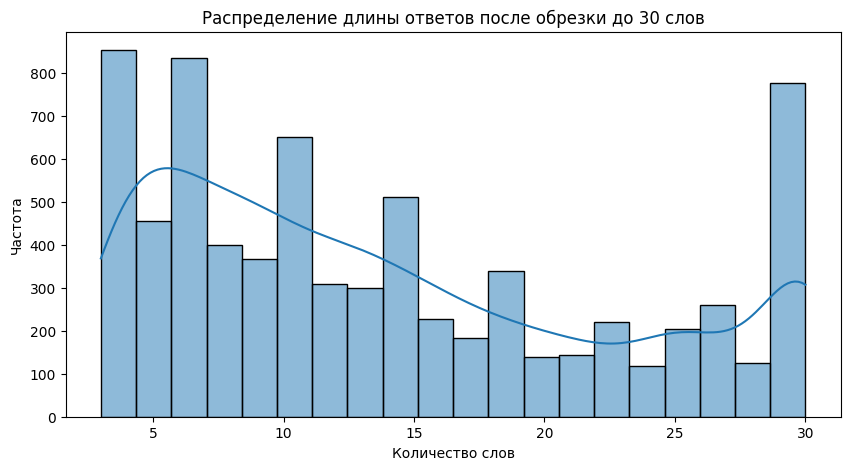

In [9]:
# Обрезка длинных реплик Хауса (больше 30 слов)
MAX_WORDS = 30

def truncate_text(text, max_words=MAX_LINE_LENGTH):
    words = text.split()
    return " ".join(words[:max_words]) if len(words) > max_words else text

house_df["line_short"] = house_df["line"].apply(lambda x: truncate_text(x) if isinstance(x, str) else x)

# Вывод статистики без дополнительной колонки
lengths = house_df["line_short"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

print("Статистика длины ответов после обрезки до 30 слов:")
print(lengths.describe())

# Визуализация
plt.figure(figsize=(10, 5))
sns.histplot(lengths, bins=20, kde=True)
plt.xlabel("Количество слов")
plt.ylabel("Частота")
plt.title("Распределение длины ответов после обрезки до 30 слов")
plt.show()


Статистика длины анкоров после обрезки до 20 последних слов:
count    7417.000000
mean        8.871377
std         5.943519
min         1.000000
25%         4.000000
50%         7.000000
75%        13.000000
max        20.000000
Name: anchor, dtype: float64


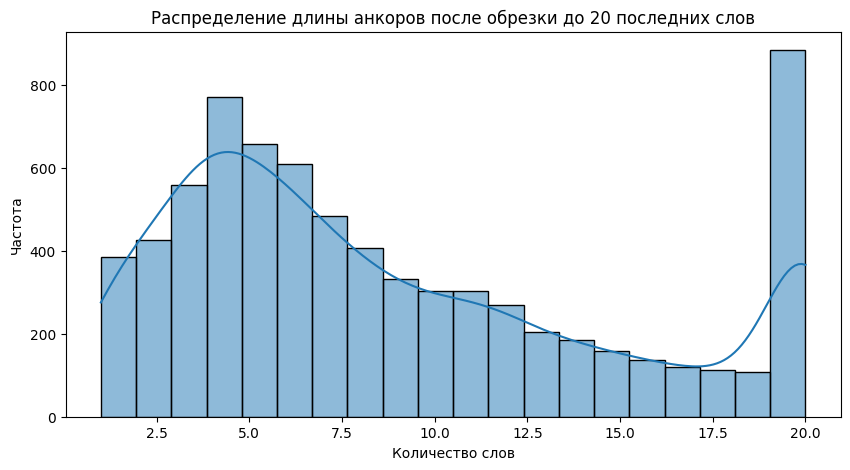

In [10]:
MAX_ANCHOR_LENGTH = 20  # Максимальная длина анкоров (последних слов)

def truncate_anchor_last_words(text, max_words=MAX_ANCHOR_LENGTH):
    words = text.split()
    if len(words) <= max_words:
        return text
    # Оставляем только последние слова
    return " ".join(words[-max_words:])

# Создание колонки anchor и копирование предыдущих реплик
house_df["anchor"] = house_df["previous_line"].apply(lambda x: truncate_anchor_last_words(x) if isinstance(x, str) else x)

# Проверка статистики
anchor_lengths = house_df["anchor"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

print("Статистика длины анкоров после обрезки до 20 последних слов:")
print(anchor_lengths.describe())

# Визуализация распределения длины анкоров
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(anchor_lengths, bins=20, kde=True)
plt.xlabel("Количество слов")
plt.ylabel("Частота")
plt.title("Распределение длины анкоров после обрезки до 20 последних слов")
plt.show()


In [11]:
# Загружается модель SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2")

# Проверка наличия нужных колонок
assert "anchor" in house_df.columns, "Колонка 'anchor' отсутствует в house_df"
assert "line_short" in house_df.columns, "Колонка 'line_short' отсутствует в house_df"

# Удаление строк, где anchor или line отсутствуют, чтобы сохранить одинаковый размер
valid_rows = house_df.dropna(subset=["anchor", "line_short"]).reset_index(drop=True)

# Векторизация анкорных реплик и их ответов
print("Векторизация анкорных реплик и ответов...")
anchor_vectors = model.encode(valid_rows["anchor"].tolist(), convert_to_numpy=True)
response_vectors = model.encode(valid_rows["line_short"].tolist(), convert_to_numpy=True)

# Проверка размеров векторов (они должны быть одинаковыми)
assert anchor_vectors.shape[0] == response_vectors.shape[0], "Размерность анкорных и ответных векторов не совпадает"

# Вычисление косинусного сходства
similarity_scores = cosine_similarity(anchor_vectors, response_vectors)
avg_similarity = np.mean(np.diag(similarity_scores))  # Берется диагональ, чтобы сравнить пары

print(f"Среднее косинусное сходство анкорных реплик и их ответов: {avg_similarity:.4f}")


Векторизация анкорных реплик и ответов...
Среднее косинусное сходство анкорных реплик и их ответов: 0.2168


In [12]:
# Фильтрация строк с пустым анкором
empty_anchor_mask = house_df["anchor"].isna()
empty_previous_lengths = house_df.loc[empty_anchor_mask, "previous_line"].dropna().apply(lambda x: len(x.split()))

# Вывод статистики
print("Статистика длины previous_line у строк с пустым анкором:")
print(empty_previous_lengths.describe())

Статистика длины previous_line у строк с пустым анкором:
count       0
unique      0
top       NaN
freq      NaN
Name: previous_line, dtype: object


In [13]:
# Загружаем модель и отправляем ее на GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# model = SentenceTransformer("all-MiniLM-L6-v2").to(device)
model = SentenceTransformer("all-mpnet-base-v2").to(device)


# Векторизация анкоров и негативных примеров
anchor_embeddings = model.encode(house_df["anchor"].tolist(), convert_to_tensor=True, device=device)
antagonist_embeddings = model.encode(antagonists_df["line"].tolist(), convert_to_tensor=True, device=device)

# Вычисление косинусного сходства
similarities = util.pytorch_cos_sim(anchor_embeddings, antagonist_embeddings).cpu().numpy()

In [14]:
threshold_lower = 0.05  # Ослабляем нижний порог
threshold_upper = 0.2   # Уменьшаем верхний порог
top_k = 50  # Расширяем выборку для негативных примеров

# Преобразование DataFrame в массивы
antagonist_lines = antagonists_df["line"].values
similarities_np = np.array(similarities)

# Создание списка для негативных примеров
new_hard_negatives = np.full(len(house_df), "", dtype=object)

for i in range(similarities_np.shape[0]):
    sorted_idx = np.argsort(similarities_np[i])[::-1]  # Сортировка по убыванию
    candidates = sorted_idx[
        (similarities_np[i][sorted_idx] > threshold_lower) &
        (similarities_np[i][sorted_idx] < threshold_upper)
    ]  # Фильтрация слишком легких и слишком похожих примеров

    if len(candidates) > 5:
        neg_idx = np.random.choice(candidates[:top_k])  # Выбираем случайный из top-k
        new_hard_negatives[i] = antagonist_lines[neg_idx]

# Добавляем в house_df колонку с негативными ответами
house_df["neg_answer"] = new_hard_negatives
print(f"Обновлено {len(new_hard_negatives)} негативных примеров.")

# === Теперь создаем триплеты ===
triplets_df = house_df[["anchor", "line_short", "neg_answer"]].copy()
triplets_df.columns = ["anchor", "response", "neg_response"]  # Переименовываем для единообразия

print(f"Создано {len(triplets_df)} триплетов.")

# Проверка на NaN
assert triplets_df.isna().sum().sum() == 0, "Есть NaN в триплетах!"


Обновлено 7417 негативных примеров.
Создано 7417 триплетов.


In [15]:
# Определение директорий для сохранения файлов
output_dir = "/content/data"
os.makedirs(output_dir, exist_ok=True)

# Пути для сохранения файлов
house_final_path = os.path.join(output_dir, "house_final_cleaned.csv")
antagonists_final_path = os.path.join(output_dir, "antagonists_final_cleaned.csv")
triplets_path = os.path.join(output_dir, "house_triplets.pkl")

# Сохранение обновлённых датасетов
house_df.to_csv(house_final_path, index=False)
antagonists_df.to_csv(antagonists_final_path, index=False)

# Проверяем, что в триплетах нет NaN перед сохранением
assert triplets_df.isna().sum().sum() == 0, "Ошибка: В триплетах есть NaN!"

# Сохранение триплетов в pickle-формате
with open(triplets_path, "wb") as f:
    pickle.dump(triplets_df, f)

print(f"Финальный датасет Доктора Хауса сохранён: {house_final_path}")
print(f"Финальный датасет антагонистов сохранён: {antagonists_final_path}")
print(f"Триплеты сохранены в: {triplets_path}")

# Автоматическая загрузка файлов для скачивания
files.download(house_final_path)
files.download(antagonists_final_path)
files.download(triplets_path)


Финальный датасет Доктора Хауса сохранён: /content/data/house_final_cleaned.csv
Финальный датасет антагонистов сохранён: /content/data/antagonists_final_cleaned.csv
Триплеты сохранены в: /content/data/house_triplets.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Пример загруженных триплетов:
                                              anchor  \
0  Fair enough. I dont like healthy Patients. The...   
1  Shouldnt we be speaking to the Patient before ...   
2      Isnt treating Patients why we became doctors?   
3                         Wernickies encephalopathy?   
4           You think we have nothing to talk about?   

                                            response  \
0          The one who cant talk, I liked that part.   
1                                    Is she a doctor   
2  No, treating illnesses is why we became doctor...   
3               No, blood thiamine lEvel was normal.   
4  No, just that I cant think of anything that Id...   

                                        neg_response  
0         That is not your concern as Master of War.  
1                  Yeah. We should do it more often.  
2  I just got out of surgery. Whats going on? Fil...  
3  Perhaps the emotion youre referring to was sho...  
4  I was going to use

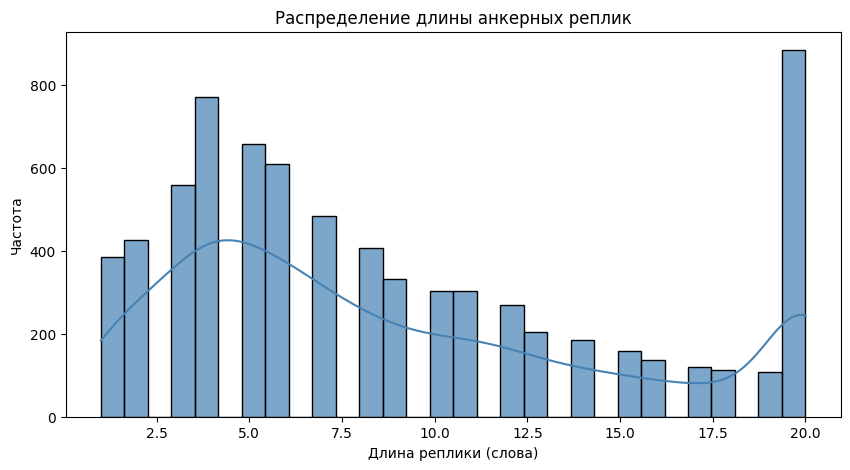

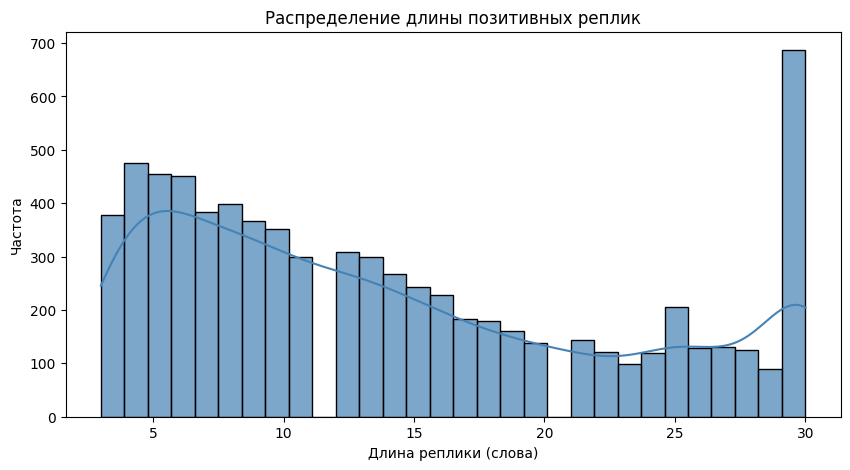

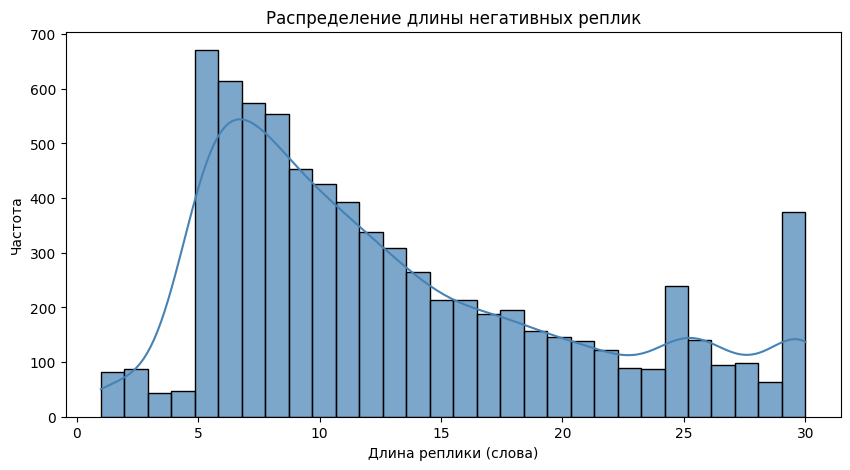

In [16]:
# Пути к сохраненным данным
triplets_path = "/content/data/house_triplets.pkl"

# Загрузка триплетов
with open(triplets_path, "rb") as f:
    triplets_df = pickle.load(f)

# Проверка структуры загруженного датафрейма
print("Пример загруженных триплетов:")
print(triplets_df.head())

# Функция для построения распределения длины реплик
def plot_length_distribution(df, column_name, title):
    lengths = df[column_name].str.split().str.len()

    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, bins=30, kde=True, color="steelblue", alpha=0.7)
    plt.xlabel("Длина реплики (слова)")
    plt.ylabel("Частота")
    plt.title(title)
    plt.show()

# Построение графиков
plot_length_distribution(triplets_df, "anchor", "Распределение длины анкерных реплик")
plot_length_distribution(triplets_df, "response", "Распределение длины позитивных реплик")
plot_length_distribution(triplets_df, "neg_response", "Распределение длины негативных реплик")

In [17]:
# Векторизация анкорных реплик, позитивных и негативных ответов
print("Векторизация анкорных реплик и ответов...")
anchor_vectors = model.encode(triplets_df["anchor"].tolist(), convert_to_numpy=True)
response_vectors = model.encode(triplets_df["response"].tolist(), convert_to_numpy=True)
negative_vectors = model.encode(triplets_df["neg_response"].tolist(), convert_to_numpy=True)

# Вычисление косинусного сходства анкорных реплик с позитивными ответами
similarity_scores = cosine_similarity(anchor_vectors, response_vectors)
avg_similarity = np.mean(similarity_scores.diagonal())

# Вычисление косинусного сходства анкорных реплик с негативными ответами
neg_similarity_scores = cosine_similarity(anchor_vectors, negative_vectors)
avg_neg_similarity = np.mean(neg_similarity_scores.diagonal())

# Вывод результатов
print(f"Среднее косинусное сходство анкорных реплик и позитивных ответов: {avg_similarity:.4f}")
print(f"Среднее косинусное сходство анкорных реплик и негативных ответов: {avg_neg_similarity:.4f}")

Векторизация анкорных реплик и ответов...
Среднее косинусное сходство анкорных реплик и позитивных ответов: 0.2168
Среднее косинусное сходство анкорных реплик и негативных ответов: 0.1996


In [18]:
# Определение директорий для сохранения
vector_output_dir = "/content/data/vectors"
os.makedirs(vector_output_dir, exist_ok=True)

# Пути для сохранения векторов
anchor_vectors_path = os.path.join(vector_output_dir, "anchor_vectors.pkl")
response_vectors_path = os.path.join(vector_output_dir, "response_vectors.pkl")
negative_vectors_path = os.path.join(vector_output_dir, "negative_vectors.pkl")

# Сохранение векторов в файлы
with open(anchor_vectors_path, "wb") as f:
    pickle.dump(anchor_vectors, f)

with open(response_vectors_path, "wb") as f:
    pickle.dump(response_vectors, f)

with open(negative_vectors_path, "wb") as f:
    pickle.dump(negative_vectors, f)

print(f"Векторы анкорных реплик сохранены в: {anchor_vectors_path}")
print(f"Векторы позитивных ответов сохранены в: {response_vectors_path}")
print(f"Векторы негативных ответов сохранены в: {negative_vectors_path}")

Векторы анкорных реплик сохранены в: /content/data/vectors/anchor_vectors.pkl
Векторы позитивных ответов сохранены в: /content/data/vectors/response_vectors.pkl
Векторы негативных ответов сохранены в: /content/data/vectors/negative_vectors.pkl


In [2]:
import pandas as pd
df = pd.read_pickle("response_vectors.pkl")
df

array([[ 0.03076261, -0.00226482, -0.00542844, ..., -0.01330738,
        -0.00024273,  0.0067468 ],
       [ 0.05197283,  0.04612171,  0.00806651, ...,  0.06618273,
        -0.01739295, -0.02856984],
       [ 0.0371306 ,  0.0561993 ,  0.0101245 , ...,  0.02226195,
         0.04300856, -0.02996873],
       ...,
       [ 0.03759895,  0.07383423, -0.03140729, ...,  0.02743934,
        -0.00074814, -0.0082609 ],
       [ 0.05370994,  0.08504163, -0.00080321, ..., -0.00152289,
        -0.00278487,  0.00850988],
       [-0.03533551, -0.00680901,  0.02775661, ...,  0.01807377,
        -0.02278693, -0.01957968]], dtype=float32)

In [11]:
# Пути к сохраненным данным
df = pd.read_pickle("house_triplets.pkl")
df

,anchor,response,neg_response
0,Fair enough. I dont like healthy Patients. The...,"The one who cant talk, I liked that part.",That is not your concern as Master of War.
1,Shouldnt we be speaking to the Patient before ...,Is she a doctor,Yeah. We should do it more often.
2,Isnt treating Patients why we became doctors?,"No, treating illnesses is why we became doctor...",I just got out of surgery. Whats going on? Fil...
3,Wernickies encephalopathy?,"No, blood thiamine lEvel was normal.",Perhaps the emotion youre referring to was sho...
4,You think we have nothing to talk about?,"No, just that I cant think of anything that Id...","I was going to use today to purge my inbox, bu..."
...,...,...,...
7412,Who says Im here to convince you to live?,Youre the last one I thought would hate me.,"Theyre coming to America, Theyre coming to Ame..."
7413,That moment with the Patient! the chunk of the...,"If it makes you feel any better, at this rate,...",I wanted to make sure were doing everything we...
7414,cared about him more than you cared about your...,"If I kept it to myself, then it would just be ...",NO ALL YOU DO IS YOU GET ME TO TRY TO WORK ON ...
7415,Youre taking the cowardly way out. And worse! ...,Youre right. But I can change.,And I cant stop you.


In [12]:
OUTPUT_NPY = "house_responses.npy"

import re
def split_sentence(text, max_sentences=2):
    sentences = re.split(r"(?<=[.!?])\s+", text)  # Разбиваем по точке, восклицательному или вопросительному знаку
    return " ".join(sentences[:max_sentences])  # Берем только первые max_sentences предложений

responses = df["response"].apply(lambda x: split_sentence(x, max_sentences=2)).tolist()

# === Сохранение ===
np.save(OUTPUT_NPY, responses)

print(f"✅ Файл {OUTPUT_NPY} создан! Количество ответов: {len(responses)}")

✅ Файл house_responses.npy создан! Количество ответов: 7417
